# Segmentation with U-Net

[Saeed Salehi]

We aim to implement a U-Net like model that takes an image of 4 digits and segments odd and even numbers to separate maps.

Reference: [U-Net paper, Ronneberger et al. 2015](https://arxiv.org/abs/1505.04597)

In [1]:
# # header
import sys
sys.path.append("./")

In [2]:
# imports
from tqdm import tqdm
from time import time
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

In [3]:
# please define the data directory
data_root = "./data"
assert os.path.exists(data_root), "Data directory not found!"


## Setup
Before going further, we need to choose the hardware to train our model on!

In [4]:
# set the device
num_workers, pin_memory = 4, False
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # NVIDIA GPU
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple Silicon (Metal)
else:
    device = torch.device("cpu") # CPU (slowest option)

print(f"Device set to {device}!")


Device set to mps!


In [5]:
# Helper function to return the number of learble parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Dataset

We use MNIST dataset to compose our own data which includes 4 digits per image.

**NOTE:** Our input data is the composition of four digits and our target output is the mask of odd and even digits. Therefore our label is not the class but the target mask.

In [6]:
train_ds = MNIST(root=data_root,  # location for the data to be downloaded if not found
                train=True,  # use the training set (if false, it will use the test set)
                transform=torchvision.transforms.ToTensor(),  # transform the data to torch tensors
                download=True,  # download the data if not found, 
)

# randomly splitting the dataset into 90% training and 10% validation
n_train = int(0.9 * len(train_ds))
n_val = len(train_ds) - n_train
train_ds, val_ds = torch.utils.data.random_split(train_ds, [n_train, n_val])


In [7]:
class OddEvenDS(Dataset):
    def __init__(self, ds_: Dataset):
        self.ds = ds_  # the vanila dataset
        self.h, self.w = 64, 64  # the new height and width
        self.noise = 0.25
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Pad((2, 2, 2, 2)),
            torchvision.transforms.RandomRotation(15),
        ])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i: int):
        m = torch.zeros(2, self.h, self.w)  # segmentation masks for the two classes
        c = torch.zeros(1, self.h, self.w)  # composite image for the digits

        for i in range(2):
            for j in range(2):
                random_idx = torch.randint(0, len(self.ds), (1,)).item()
                x, y = self.ds.__getitem__(random_idx)
                x = self.transform(x)
                c[:, i*32:(i+1)*32, j*32:(j+1)*32] = x
                m[y%2, i*32:(i+1)*32, j*32:(j+1)*32] = x[0]
        
        c += self.noise * torch.randn_like(c)
        c = c.clamp(0.0, 1.0)

        return c, m


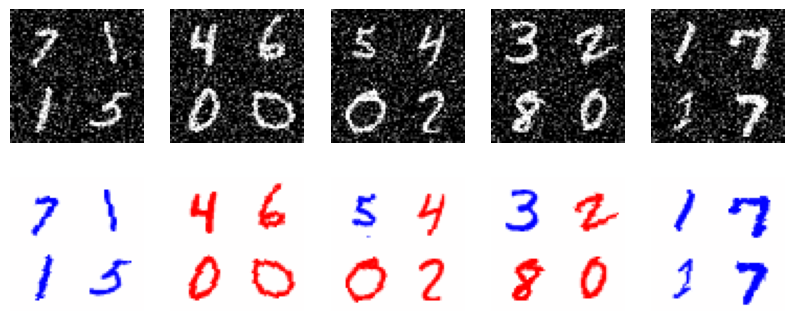

In [8]:
train_ds_seg = OddEvenDS(train_ds)
valid_ds_seg = OddEvenDS(val_ds)

# plotting the first 5 images and their masks
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    c, m = train_ds_seg[i]
    axs[0, i].imshow(c[0], cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(m[0] - m[1], cmap="bwr", vmin=-1, vmax=1)
    axs[1, i].axis("off")
plt.show()

## Model Architecture

Given the simplicity of our task, we use a simple and small U-Net model. The model has an encoder, a decoder, and 3 skip connections. The feature maps from encoder are concatenated to the corresponding decoder feature maps. Your task is to complete the encoder.

**NOTE:** All the `Conv2d` layers (the red arrows) should have `stride=1, padding='same'`

![Model Architecture](figures/unet_1.png)

Figure adopted from U-Net paper, Ronneberger et al. 2015

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # input shape = (1, 64, 64)
        # # Encoder # # # # # # # # # # # # # # # # # # # # # # # # 
        # >>>>> YOUR CODE HERE
        # raise NotImplementedError("Replace this line by your code.")
        # self.conv1enc = ...  # output shape = (4, 64, 64)
        # self.conv2enc = ...  # output shape = (4, 64, 64)
        # self.maxpool1 = ...  # output shape = (4, 32, 32)

        # self.conv3enc = ...  # output shape = (8, 32, 32)
        # self.conv4enc = ...  # output shape = (8, 32, 32)
        # self.maxpool2 = ...  # output shape = (8, 16, 16)

        # self.conv5enc = ...  # output shape = (16, 16, 16)
        # self.conv6enc = ...  # output shape = (16, 16, 16)
        # self.maxpool3 = ...  # output shape = (16, 8, 8)

        # self.conv7enc = ...  # output shape = (32, 8, 8)
        # self.conv8enc = ...  # output shape = (32, 8, 8)
        # <<<<< END YOUR CODE
        
        self.conv1enc = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding='same')
        # output shape = (4, 64, 64)
        self.conv2enc = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding='same')
        # output shape = (4, 64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # output shape = (4, 32, 32)
        
        self.conv3enc = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding='same')
        # output shape = (8, 32, 32)
        self.conv4enc = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding='same')
        # output shape = (8, 32, 32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # output shape = (8, 16, 16)

        self.conv5enc = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding='same')
        # output shape = (16, 16, 16)
        self.conv6enc = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same')
        # output shape = (16, 16, 16)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # output shape = (16, 8, 8)
        
        self.conv7enc = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        # output shape = (32, 8, 8)
        self.conv8enc = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same')
        # output shape = (32, 8, 8)
        # # End of Encoder # # # # # # # # # # # # # # # # # # # # 

        # # Decoder # # # # # # # # # # # # # # # # # # # # # # # # 
        self.upsamp1 = nn.Upsample(size=(16, 16))
        # output shape = (32, 16, 16)
        self.upconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        # output shape = (16, 16, 16)

        self.conv1dec = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding='same')
        # output shape = (16, 16, 16)
        self.conv2dec = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same')
        # output shape = (16, 16, 16)

        self.upsamp2 = nn.Upsample(size=(32, 32))
        # output shape = (16, 32, 32)
        self.upconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
        # output shape = (8, 32, 32)

        self.conv3dec = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding='same')
        # output shape = (8, 32, 32)
        self.conv4dec = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding='same')
        # output shape = (8, 32, 32)

        self.upsamp3 = nn.Upsample(size=(64, 64))
        # output shape = (8, 64, 64)
        self.upconv3 = nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)
        # output shape = (4, 64, 64)

        self.conv5dec = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding='same')
        # output shape = (4, 64, 64)
        self.conv6dec = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding='same')
        # output shape = (4, 64, 64)
        self.conv7dec = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=1, stride=1, padding='same')
        # # End of Decoder # # # # # # # # # # # # # # # # # # # # 
        # output shape = (2, 64, 64)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1enc(x))
        x = h1 = F.relu(self.conv2enc(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv3enc(x))
        x = h2 = F.relu(self.conv4enc(x))
        x = self.maxpool2(x)
        
        x = F.relu(self.conv5enc(x))
        x = h3 = F.relu(self.conv6enc(x))
        x = self.maxpool3(x)
        
        x = F.relu(self.conv7enc(x))
        x = F.relu(self.conv8enc(x))
        
        # Decoder
        x = self.upconv1(self.upsamp1(x))
        x = torch.cat([h3, x], dim=1).contiguous()
        x = F.relu(self.conv1dec(x))
        x = F.relu(self.conv2dec(x))
        
        x = self.upconv2(self.upsamp2(x))
        x = torch.cat([h2, x], dim=1).contiguous()
        x = F.relu(self.conv3dec(x))
        x = F.relu(self.conv4dec(x))
        
        x = self.upconv3(self.upsamp3(x))
        x = torch.cat([h1, x], dim=1).contiguous()
        x = F.relu(self.conv5dec(x))
        x = F.relu(self.conv6dec(x))
        x = self.conv7dec(x)
        return x


In [10]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    
    # Set network to training mode
    model.train()
    
    # Move model to device
    model.to(device)
    
    # Iterate over dataset
    losses = list()
    for composite, target in data_loader:
        # Move data to device
        composite, target = composite.to(device), target.to(device)
        
        # Compute output
        output = model(composite)
        
        # Compute crossentropy loss
        loss = criterion(output, target)
        
        # Track losses
        losses.append(loss.item())
        
        # Clear gradients
        optimizer.zero_grad(set_to_none=True)

        # Compute gradient
        loss.backward()
        
        # Perform gradient descent
        optimizer.step()

    # Set network to evaluation mode
    model.eval()

    # Return loss at end of epoch
    return losses


def eval_function(model, data_loader, criterion, device):
    
    mask_loss = 0.0  # loss for the entire dataset

    # Set network to training mode
    model.eval()
    
    # Move model to device
    model.to(device)

    with torch.no_grad():
        # Iterate over dataset
        for composite, target in data_loader:
            # Move data to device
            composite, target = composite.to(device), target.to(device)

            # Compute output
            output = model(composite)
            
            # Compute the loss
            loss = criterion(output, target)
            mask_loss += loss.item() * composite.size(0)

    return mask_loss / len(data_loader.dataset)


## Training

Two of the main hyper-parameters are the batch-size and learning rate. We have already performed a small grid search and found the `batch_size = 256` of 256 and `lr=0.002` work well.  We use MSE as our loss-objective and will NOT use any regularization terms.

In [11]:
# creating the dataloaders
batch_size = 256  # the number of samples per batch
# >>>>> YOUR CODE HERE
# raise NotImplementedError("Replace this line by your code.")
train_dataloader = DataLoader(train_ds_seg,  # the dataset to be used
                              batch_size=batch_size,  # the number of samples per batch
                              shuffle=True,  # shuffle the dataset at every epoch
                              )

val_dataloader = DataLoader(valid_ds_seg,  # the dataset to be used
                            batch_size=batch_size,  # the number of samples per batch
                            shuffle=False,  # do not shuffle the dataset
                            )
# <<<<< END YOUR CODE


In [12]:
# creating the model, optimizer and loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = F.mse_loss
print(model)
print(f"The model has {count_parameters(model):,} learnable parameters.")

Net(
  (conv1enc): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2enc): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3enc): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4enc): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5enc): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6enc): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7enc): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8enc): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (upsamp1): Upsample(size=(16, 16), mode='nearest')
  (upconv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), str

In [13]:
# training and evaluating the model
losses = list()
print(f"Validation Mask loss before training: {eval_function(model, val_dataloader, criterion, device):.5f}")
for epoch in tqdm(range(5)):
    epoch_losses = train_epoch(model, train_dataloader, optimizer, criterion, device)
    losses.extend(epoch_losses)
print(f"Validation Mask loss after training: {eval_function(model, val_dataloader, criterion, device):.5f}")

Validation Mask loss before training: 0.05014


100%|██████████| 5/5 [04:27<00:00, 53.42s/it]


Validation Mask loss after training: 0.00312


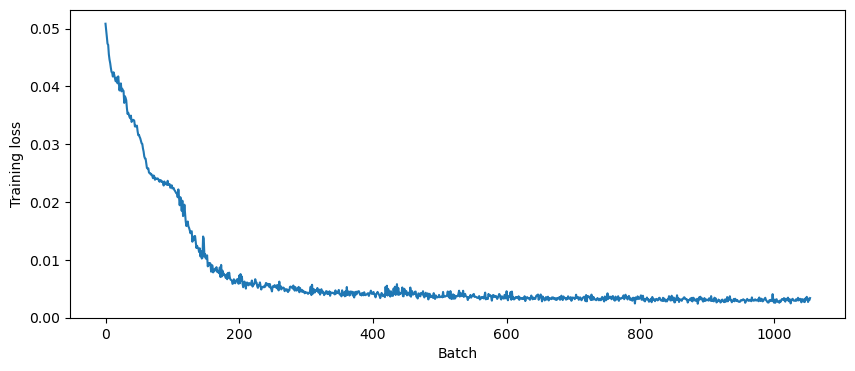

In [14]:
# plotting the loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Training loss")
plt.show()

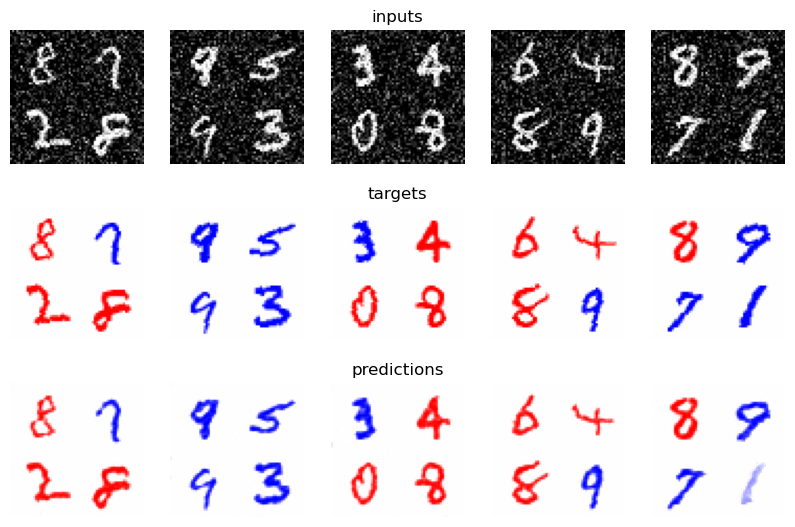

In [15]:
# plotting the first 5 images, target masks and predicted masks
model.eval()
model.to("cpu")
fig, axs = plt.subplots(3, 5, figsize=(10, 6.5))
with torch.no_grad():
    composite, target = next(iter(val_dataloader))
    output = model(composite).detach().cpu()
    for i in range(5):
        if i == 2:
            axs[0, i].set_title("inputs")
            axs[1, i].set_title("targets")
            axs[2, i].set_title("predictions")
        axs[0, i].imshow(composite[i][0], cmap="gray")
        axs[0, i].axis("off")
        axs[1, i].imshow(target[i][0] - target[i][1], cmap="bwr", vmin=-1, vmax=1)
        axs[1, i].axis("off")
        axs[2, i].imshow(output[i][0] - output[i][1], cmap="bwr", vmin=-1, vmax=1)
        axs[2, i].axis("off")
plt.show()
